In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
data_folder = "gdrive/MyDrive/PACS"

In [18]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install matplotlib==3.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fyd78ry8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fyd78ry8
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 69.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.0
    Uninstalling matplotlib-3.4.0:
      Succ

In [3]:
import clip
import os
import torch
import numpy as np
from PIL import Image

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [13]:
art_dir = data_folder + os.path.sep + "art_painting" + os.path.sep
cartoon_dir = data_folder + os.path.sep + "cartoon" + os.path.sep
photo_dir = data_folder + os.path.sep + "photo" + os.path.sep
sketch_dir = data_folder + os.path.sep + "sketch" + os.path.sep

classes = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
# pacs_dirs = [art_dir, cartoon_dir, photo_dir, sketch_dir]

# classes = ["dog", "elephant"]
pacs_dirs = [sketch_dir]

In [14]:
directory_images = {}
true_count_dict = {}
images = []
actual_label = []
for directory_name in pacs_dirs:
    directory_images[directory_name] = {}
    true_count_dict[directory_name.split(os.path.sep)[-2]] = {}

    for folder in os.listdir(directory_name):
        if folder in classes:
            directory_images[directory_name][folder] = []
            true_count_dict[directory_name.split(os.path.sep)[-2]][folder] = {}
            true_count_dict[directory_name.split(os.path.sep)[-2]][folder]["true_count"] = 0
            true_count_dict[directory_name.split(os.path.sep)[-2]][folder]["pred_count"] = 0
            for file in os.listdir(directory_name + folder):
                file_path = directory_name + folder + os.path.sep + file
                true_count_dict[directory_name.split(os.path.sep)[-2]][folder]["true_count"] += 1

                text = f"This is a photo of a {folder}"
                directory_images[directory_name][folder].append(
                    (file_path, text))
                images.append(preprocess(Image.open(file_path).convert("RGB")))
                actual_label.append(directory_name + folder)

In [15]:
text_descriptions = [f"This is a photo of a {label}" for label in classes]
text_tokens = clip.tokenize(text_descriptions).to(device)
image_input = torch.tensor(np.stack(images)).to(device)

In [16]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

image_features /= image_features.norm(dim=-1, keepdim=True)

In [17]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)

In [18]:
result = true_count_dict

for i, _ in enumerate(image_input):
    type_d = actual_label[i].split(os.path.sep)[-2]
    true_class = actual_label[i].split(os.path.sep)[-1]
    pred_class = [classes[index] for index in top_labels[i].numpy()][0]
    if true_class == pred_class:
      if true_class not in result[type_d]:
        result[type_d][true_class]["pred_count"] = 1
      else:
        result[type_d][true_class]["pred_count"] += 1

In [19]:
count_dict = {}
for k, v in result.items():
  for k1, v1 in v.items():
    count_dict[k1] = {"true_count" : v1["true_count"], "pred_count" : v1["pred_count"]}
count_dict

{'elephant': {'true_count': 740, 'pred_count': 679},
 'giraffe': {'true_count': 753, 'pred_count': 477},
 'horse': {'true_count': 816, 'pred_count': 805},
 'guitar': {'true_count': 608, 'pred_count': 600},
 'house': {'true_count': 80, 'pred_count': 79},
 'person': {'true_count': 160, 'pred_count': 149},
 'dog': {'true_count': 772, 'pred_count': 568}}

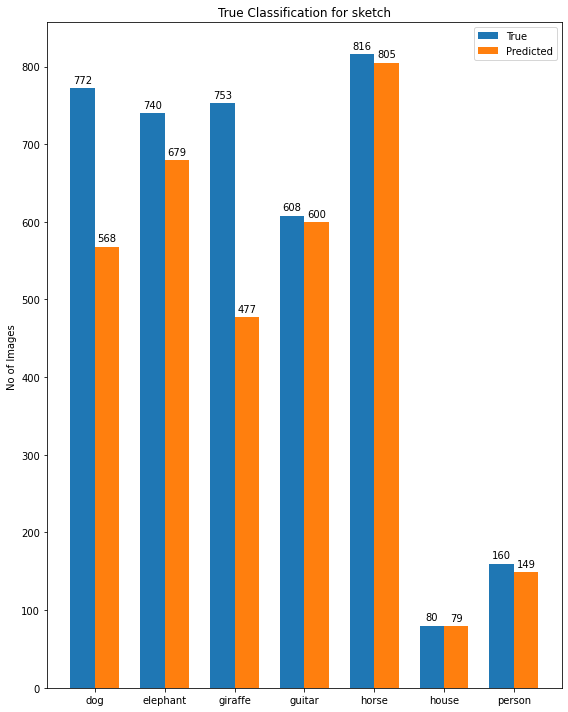

In [20]:
import matplotlib.pyplot as plt
import numpy as np

type_image = "sketch"

labels = classes
true_count = [count_dict[i]["true_count"] for i in labels]
predicted_count = [count_dict[i]["pred_count"] for i in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 10))
rects1 = ax.bar(x - width/2, true_count, width, label='True')
rects2 = ax.bar(x + width/2, predicted_count, width, label='Predicted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No of Images ')
ax.set_title('True Classification for ' + type_image)
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
!pip list